# TASK 1: 

Di seguito è proposto il calcolo dell'indice di El-Ninō 3.4 (Riferimento spaziale all'area del
Pacifico in cui tale indice viene calcolato: vedere: 
<https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni>
per maggiori dettagli) dai dati del dataset dello Storico(!=OSSERVATO)

- Il calcolo è proposto in tre diversi metodi per i quali ne si è verificata la differenza.
Vedere le rispettive celle per i dettagli e il file di testo che spiega in modo dettaglaito l'operato.

- Infine è stata valutata la regressione lineare tra la SST e l'indice Nino3.4 su tutto il globo.
Tale regressione indica l'amplidficazione/il riscaldamento/raffreddamento della SST nelle varie zone del
globo a seguito di un evento di el-nino o la-nina.


In [ ]:
# import libraries
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4
import pickle
from scipy import signal, stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import AllePowerFunctions as apf
import climtools_lib as ctl

In [2]:
# Comando che rende le immagini generate visualizzabili
%matplotlib inline

In [12]:
# Acquisizione dei dati
Dir_SST = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/r4i1p1f1/Omon/tos_rg_1850-2014.nc'
Dir_output = '/home/montanarini/ELNINO/output/Task-1_Hist/'
Dir_images = '/home/montanarini/ELNINO/images/Task-1_HistSST/'
#FILE_Toss=xr.open_mfdataset("C:/Users/aless/Desktop/Task1/tos/*.nc", engine="netcdf4")
#FILE_Toss = xr.merge([xr.open_dataset(f) for f in glob.glob('C:/Users/aless/Desktop/Task1/tos/*.nc')]) 
            #A differenza del primo metodo qua i dati dei file vengono aperti e presi in memoria
            #---> se la mole di file è grande ci vuole del tempo e puù succedere che non ci sia 
            #abbastanza memoria per tenerli in memoria  tutti
temp=xr.open_dataset(Dir_SST)
temp

<xarray.Dataset>
Dimensions:  (time: 1980, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes:
    regrid_method:  bilinear

In [4]:
temp.info()

xarray.Dataset {
dimensions:
	time = 1980 ;
	lat = 180 ;
	lon = 360 ;

variables:
	float32 tos(time, lat, lon) ;
	datetime64[ns] time(time) ;
	float64 lon(lon) ;
	float64 lat(lat) ;

// global attributes:
	:regrid_method = bilinear ;
}

In [ ]:
######################################################
############DataSet Managing: Method 1################
######################################################

'''
 Calcolo della variaible SST osservata ed eventuale ridimensionamento
 Calcolo del Tred storico in 3 differenti modi, su tutta la matrice (dataset) ritagliato, e conseguente detrazione
        -Lineare
        -Polinomiale con grado = 3
        -Running mean con Dt=30anni
 Calcolo dell'Anomalia
 Calcolo del Seasonal Cycle (e detrazione di esso dall'anomalia)
 Calcolo dell'indice Nino 3.4
'''
# Passaggio da XarrayDataset a XarrayDataArray 
Toss=temp['tos'];
# Ridimensionamento
Toss34=Toss.sel(lat=slice(-5,5), lon=slice(190,240))

# Estrazione Coordinate
lon=Toss34['lon'];
lat=Toss34['lat'];
time=Toss34['time'];

anom_month_trend_sc = Toss34 - Toss34.mean('time') # Anomalia che contiene il cilco stagionale e quello storico

### Metodo 1: Lineare.
Toss34_detrended_linear = signal.detrend(Toss34, axis=0, type='linear', bp=0, overwrite_data=False)
Toss34_detrended_linear = xr.DataArray(Toss34_detrended_linear, # Ritrasformazione in DataArray
        dims=['time', 'lat', 'lon'], coords={'time':time, 'lat':lat, 'lon':lon})
# Media climatica totale
Tmean = Toss34_detrended_linear.mean('time') # Media climatologica della Toss (media sui 165 anni)
## Anomalia
# Calcolata attraverso i dati annuali-->il seasonal cycle non c'è visto che il campionamento è annuale
anom_year_linear = Toss34_detrended_linear.groupby('time.year').mean('time') #len(coord. tempo) = 165
# Calcolata attraverso i dati mensili
anom_month_linear_sc = Toss34_detrended_linear - Tmean # Anomalia, contiene il ciclo stagionale ma non il trend storico
anom_month_linear = (Toss34_detrended_linear.groupby('time.month') -  # Totalmente detrendato
                   Toss34_detrended_linear.groupby('time.month').mean('time'))
seasonal_cycle = anom_month_linear_sc-anom_month_linear

### Metodo 2: Polinomiale, con grado = 3. Qui per necessità prima calcolo l'indice poi rimuovo il trend.
anom_month_trend = (Toss34.groupby('time.month') - # Anomalia, contiene il trend storico lineare ma non il SC
                   Toss34.groupby('time.month').mean('time'))
timePol = time.values # Estraggo le coordinate time come array di datetime64
timePol = (timePol - timePol[0]).astype('timedelta64[D]').astype(int) # Convertire le date in giorni trascorsi dal primo punto temporale
# Media spaziale
Index_MonthPol = ctl.global_mean(anom_month_trend, latitude = None, mask = None, skip_nan = True)
# Rimozione del trend
coeff = np.polyfit(timePol, Index_MonthPol, 3) # Calcola i coefficienti del polinomio di terzo grado
pol_trend = np.polyval(coeff, timePol) # Calcola il trend polinomiale utilizzando i coefficienti
Index_MonthPol = Index_MonthPol - pol_trend # Sottrai il trend polinomiale all'indice

### Metodo 3: 30-years Running Mean
# Trend storico
running_mean = Toss34.rolling(time=360, min_periods=1, center=True).mean() # Running Mean 
trend_storico = ctl.global_mean(running_mean.groupby('time.month')-running_mean.groupby('time.month').mean('time')) # Trend storico dato dalla RM
Anom_DetrendedRM = Toss34 - running_mean # Rimozione trend storico, rimane un Anomalia con il Seasonal Cycle
trend_storico = Toss34 - (Anom_DetrendedRM + Toss34.mean('time'))
# Anmalia calcolata attraverso la media sui mesi--> rimuoviamo così il seasonal cycle
Anom_meanMonthRM = (Anom_DetrendedRM.groupby('time.month') - 
                   Anom_DetrendedRM.groupby('time.month').mean('time'))
# Ciclo Stagionale
seasonal_cycle = Anom_DetrendedRM - Anom_DetrendedRM.mean('time') - Anom_meanMonthRM

### Ninõ Index
#Eseguo una media spaziale sul box considerato: uso ctl.global_mean() perchè la media zonale con xarray: .mean(['lat', 'lon']) o equivalentemente: .mean('lat').mean('lon'), non considera il coseno della latitudine quindi commette un errore tanto più grande quanto ci si avvicina ai poli
Index_YearLinear = ctl.global_mean(anom_year_linear, latitude = None, mask = None, skip_nan = True) #anom_year_linear.mean('lat').mean('lon') # Annuale, no Trend storico, no SC
Index_MonthLinearSC = ctl.global_mean(anom_month_linear_sc, latitude = None, mask = None, skip_nan = True) # Mensile, no Trend storico, si SC
Index_MonthTrend = ctl.global_mean(anom_month_trend, latitude = None, mask = None, skip_nan = True) # Mensile, Trend storico, no SC
Index_MonthTrendSC = ctl.global_mean(anom_month_trend_sc, latitude = None, mask = None, skip_nan = True) # Mensile, si Trend storico, si SC
Index_MonthLinear = ctl.global_mean(anom_month_linear, latitude = None, mask = None, skip_nan = True) # Mensile, no Trend storico, no SC
Index_MonthRM = ctl.global_mean(Anom_meanMonthRM, latitude = None, mask = None, skip_nan = True) # Mensile, no Trend storico, no SC

# In Numpy
# Index_YearLinear=np.average(anom_year_linear, axis=(1,2)) #Media spaziale
# Index_MonthLinear=np.average(anom_month_linear, axis=(1,2)) #Media spaziale

### Power Spectra (one-dimensional discrete Fourier Transform) 
spec = np.fft.fft(Index_MonthRM, n=None, axis=0) # Segnale nello spazio delle fasi (in funzione delle frq)
power_spec = np.abs(spec)**2 # Energia o potenza associata ad ogni freq
power_spec_den = ctl.running_mean(power_spec, 1) # Running mean per smoothare un pò di rumore
freqs = np.fft.fftfreq(Index_MonthRM.size, 1) # Calcolo delle frequenze
idx = freqs > 0

### Standard Deviations
# STD totale: su tutto l'array/la serie temporale
stdT_Year1 = np.std(Index_YearLinear.to_numpy())
stdT_Month1 = np.std(Index_MonthLinear.to_numpy())
stdT_MonthPol = np.std(Index_MonthPol)
stdT_MonthRM = np.std(Index_MonthRM.to_numpy()) #Calcolata dalla funzione
print(stdT_Year1, stdT_Month1, stdT_MonthPol, stdT_MonthRM)

stdT_MonthRM, std100_MonthRM, stdRM_MonthRM =  apf.standard_deviation(Index_MonthRM, 360, 100, 'time')

### Per la Composite
Index_MonthRM_Nino = Index_MonthRM.where(Index_MonthRM.rolling(time=6, center=True).mean().dropna("time")>=0.4)
Index_MonthRM_Nina = Index_MonthRM.where(Index_MonthRM.rolling(time=6, center=True).mean().dropna("time")<=-0.4)

### Time Coordinate managing
time_array = np.array(time['time'])

years_index = pd.DatetimeIndex(time_array)

years = years_index.year
unique_years = np.unique(years) #Serie temporale degli anni

years_array = unique_years - np.min(unique_years) #Questo per avere un array che parte da 0 e va in su.

0.6165855513763404 0.830431449669446 <xarray.DataArray 'tos' ()>
array(0.82801119) 0.8249319497546191
STD completed in 0:00:00.000075
Running STD completed in 0:00:00.000293
Last 100 years STD completed in 0:00:00.002909


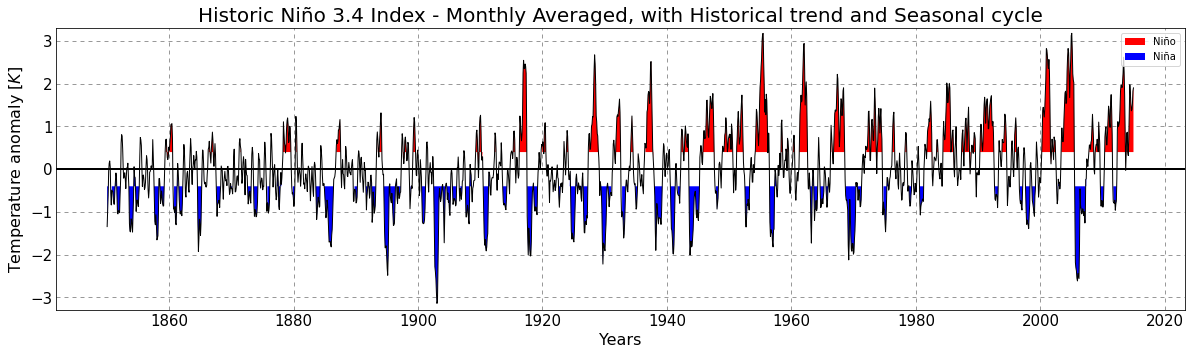

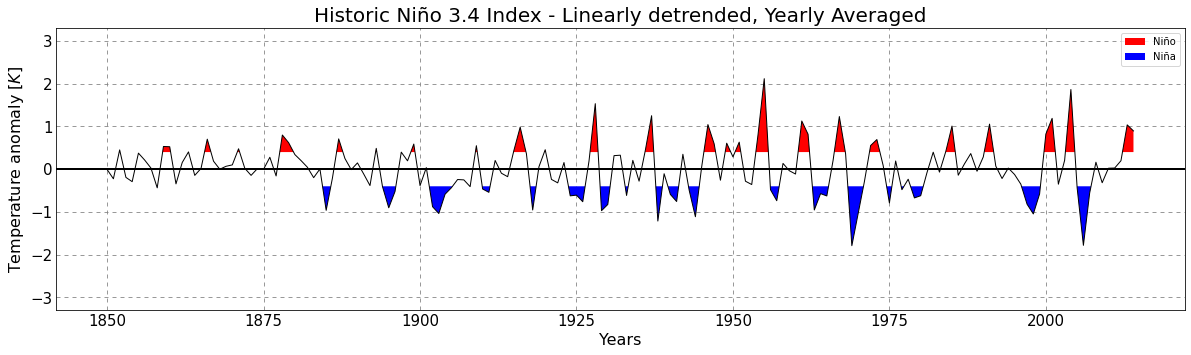

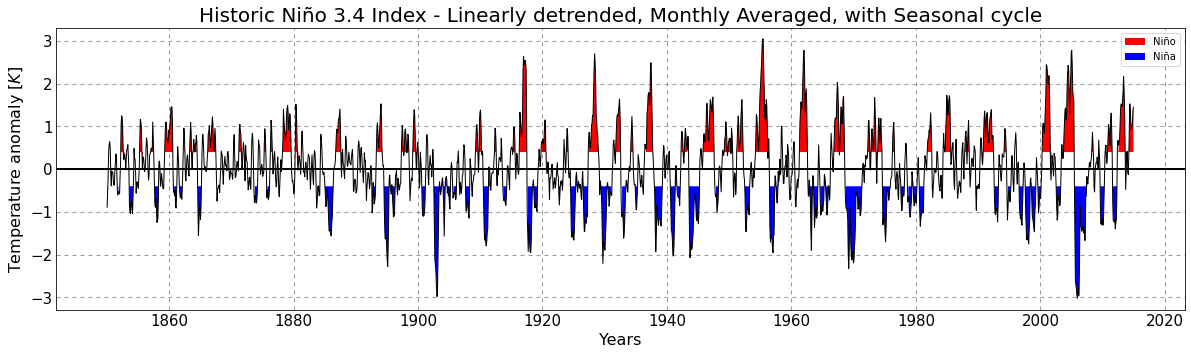

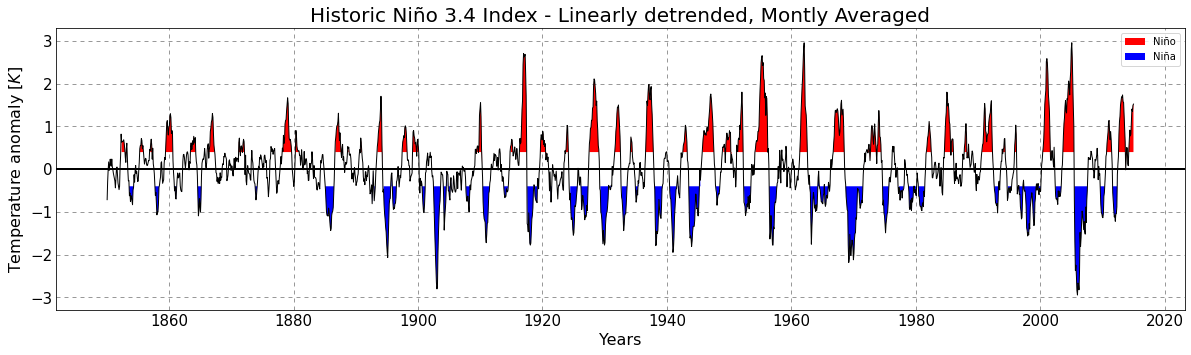

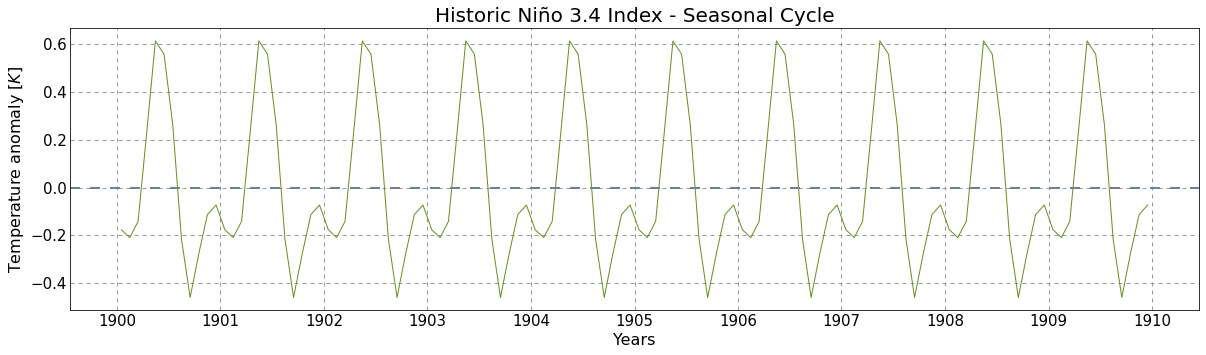

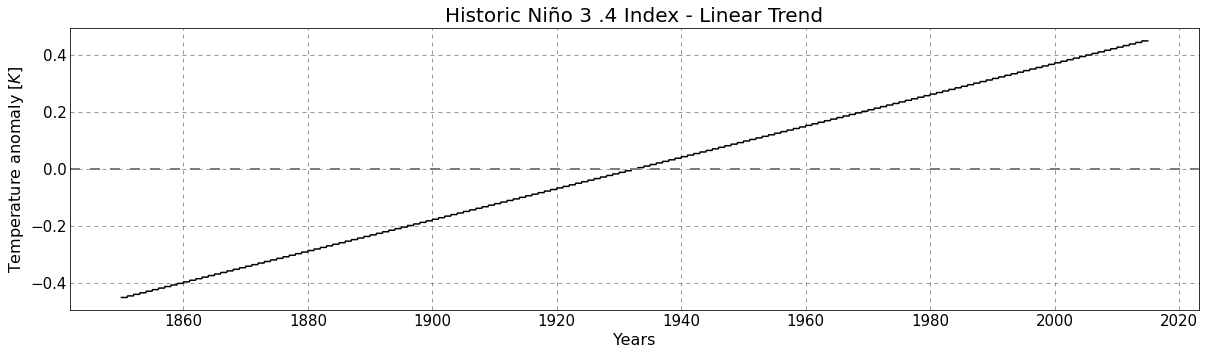

In [ ]:
###################################################################################
############################### Trend Lineare #####################################
###################################################################################


###################################################################################
###################### Ninõ Index, averaged over months ###########################
###################################################################################

plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(temp['time'], Index_MonthTrendSC,  color='k', linewidth=1.0)
ax.fill_between(temp['time'], 0.4,  Index_MonthTrendSC, where = Index_MonthTrendSC.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red',
                interpolate=True, label='Niño')
ax.fill_between(temp['time'], -0.4, Index_MonthTrendSC, where = Index_MonthTrendSC.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue',
                interpolate=True, label='Niña')
# Add a legend on the Axes
ax.legend(loc = 'upper right')
ax.set_ylim(-3.3, 3.3) 
#ax.set_xlim(temp['time'][600], temp['time'][720])
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index - Monthly Averaged, with Historical trend and Seasonal cycle', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, color='black', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-MonthHTSC.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-MonthHTSC.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

###################################################################################
####################### Ninõ Index, time mean over Years ##########################
###################################################################################

########Qui Index_YearLinear ha una lenght della dimensione tempo di 165################

plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(unique_years, Index_YearLinear,  color='k', linewidth=1.0)
ax.fill_between(unique_years, 0.4,  Index_YearLinear, where= Index_YearLinear >=0.4, facecolor='red',
                interpolate=True, label='Niño')
ax.fill_between(unique_years, -0.4, Index_YearLinear, where=Index_YearLinear <= -0.4, facecolor='blue',
                interpolate=True, label='Niña')
# Add a legend on the Axes
ax.legend(loc = 'upper right')
ax.set_ylim(-3.3, 3.3) 
                     #----> se compare il 3.3 agli estremi allora fai: dei ax.yticks(np.arange(-3, 3, 1)) o linspace(-3,3,7)
#ax.set_xlim(temp['time'][600], temp['time'][720])
#ax.set(xlim=(0, 8), xticks=np.arange(1, 8), ylim=(0, 8), yticks=np.arange(1, 8))
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index - Linearly detrended, Yearly Averaged', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, color='black', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-LinearYear.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-LinearYear.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

###################################################################################
#################### Ninõ Index, averaged over months ##############################
###################################################################################

########Qui Index_MonthLinearSC ha una lenght della dimensione tempo di 1980##############

plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(temp['time'], Index_MonthLinearSC,  color='k', linewidth=1.0)
ax.fill_between(temp['time'], 0.4,  Index_MonthLinearSC, where = Index_MonthLinearSC.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red',
                interpolate=True, label='Niño')
ax.fill_between(temp['time'], -0.4, Index_MonthLinearSC, where = Index_MonthLinearSC.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue',
                interpolate=True, label='Niña')
# Add a legend on the Axes
ax.legend(loc = 'upper right')
ax.set_ylim(-3.3, 3.3) 
#ax.set_xlim(temp['time'][600], temp['time'][720])
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index - Linearly detrended, Monthly Averaged, with Seasonal cycle', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, color='black', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-LinearMonthSC.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-LinearMonthSC.jpg',bbox_inches='tight', dpi=150)
#####################################################################################



###################################################################################
####################### Ninõ Index, time mean over Months #########################
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(temp['time'], Index_MonthLinear,  color='k', linewidth=1.0)
ax.fill_between(temp['time'], 0.4,  Index_MonthLinear, where = Index_MonthLinear.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red',
                interpolate=True, label='Niño')
ax.fill_between(temp['time'], -0.4, Index_MonthLinear, where = Index_MonthLinear.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue',
                interpolate=True, label='Niña')
# Add a legend on the Axes
ax.legend(loc = 'upper right')
ax.set_ylim(-3.3, 3.3) 
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index - Linearly detrended, Montly Averaged', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, color='black', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-LinearMonth.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-LinearMonth.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

###################################################################################
####################### Ninõ Index Seasonal Cycle #################################
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(temp['time'].sel(time=slice('1900-01-01','1910-01-01')), (Index_MonthLinearSC-Index_MonthLinear).sel(time=slice('1900-01-01','1910-01-01')),  color='olivedrab', linewidth=1.0)
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index - Seasonal Cycle', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, linestyle='--', color='slategray', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-SeasonalCycleLinear.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-SeasonalCycleLinear.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

###################################################################################
####################### Ninõ Index Linear trend ###################################
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(temp['time'], Index_MonthTrend-Index_MonthLinear,  color='k', linewidth=1.5) #color='dodgerblue'
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3 .4 Index - Linear Trend', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, linestyle='--', color='slategray', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-LinearTrend.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-LinearTrend.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

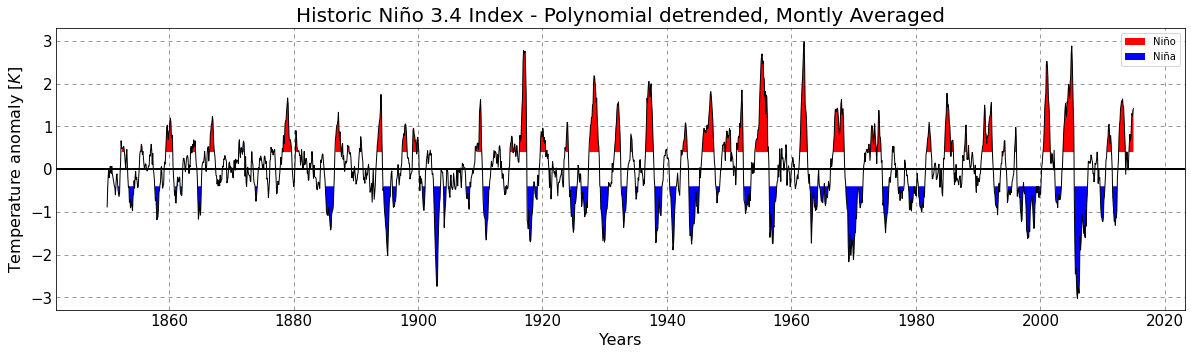

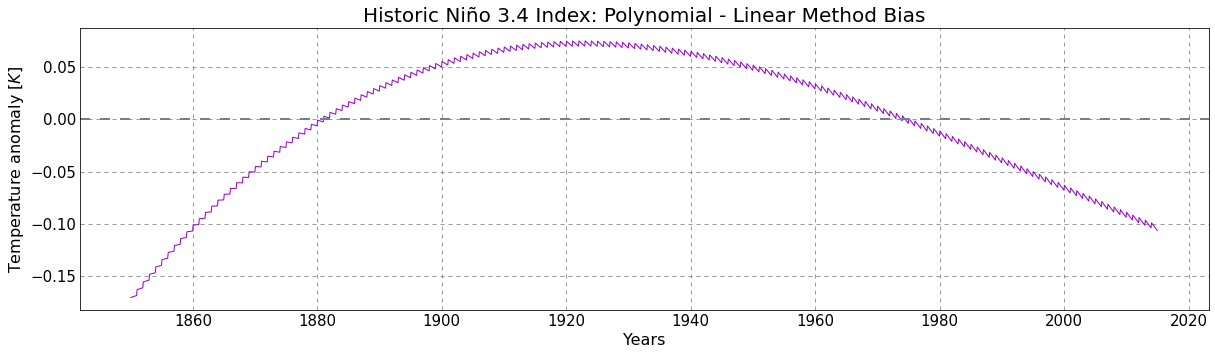

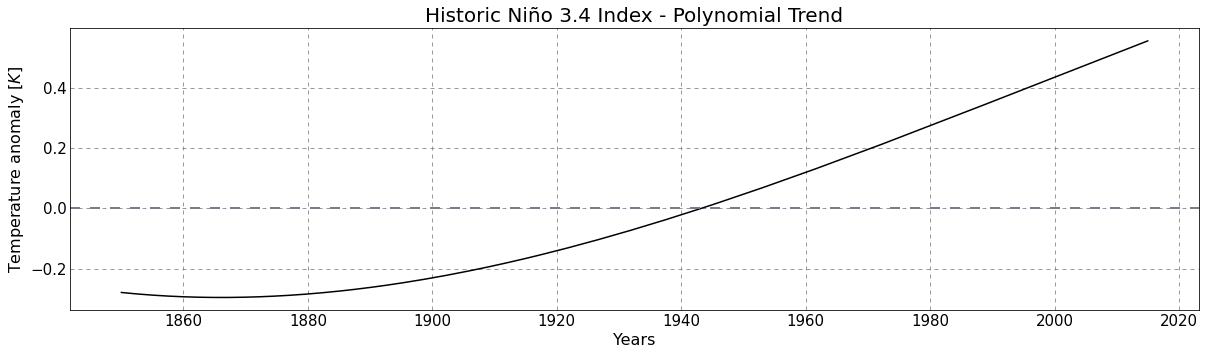

In [ ]:
###################################################################################

#########################Trend Polinomiale (grado=3)###############################

###################################################################################



###################################################################################
#############Ninõ Index, Polinomial Detrending, time mean over Months##############
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(temp['time'], Index_MonthPol,  color='k', linewidth=1.0)
ax.fill_between(temp['time'], 0.4,  Index_MonthPol, where = Index_MonthPol.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red',
                interpolate=True, label='Niño')
ax.fill_between(temp['time'], -0.4, Index_MonthPol, where = Index_MonthPol.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue',
                interpolate=True, label='Niña')
# Add a legend on the Axes
ax.legend(loc = 'upper right')
# Set title and x-y axis labels for the Axes
ax.set_ylim(-3.3, 3.3) 
ax.set_title('Historic Niño 3.4 Index - Polynomial detrended, Montly Averaged', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, color='black', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-PolMonths.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-PolMonths.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

###################################################################################
###############Ninõ Index Bias: Polynomial - Lynear detrending#####################
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(temp['time'], Index_MonthPol-Index_MonthLinear,  color='darkviolet', linewidth=1.0)
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index: Polynomial - Linear Method Bias', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, linestyle='--', color='slategray', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-BiasPolLinear.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-BiasPolLinear.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

###################################################################################
########################Ninõ Index Linear trend####################################
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(temp['time'], pol_trend,  color='k', linewidth=1.5) #color='dodgerblue'
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index - Polynomial Trend', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, linestyle='--', color='slategray', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-pol_trend.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-pol_trend.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

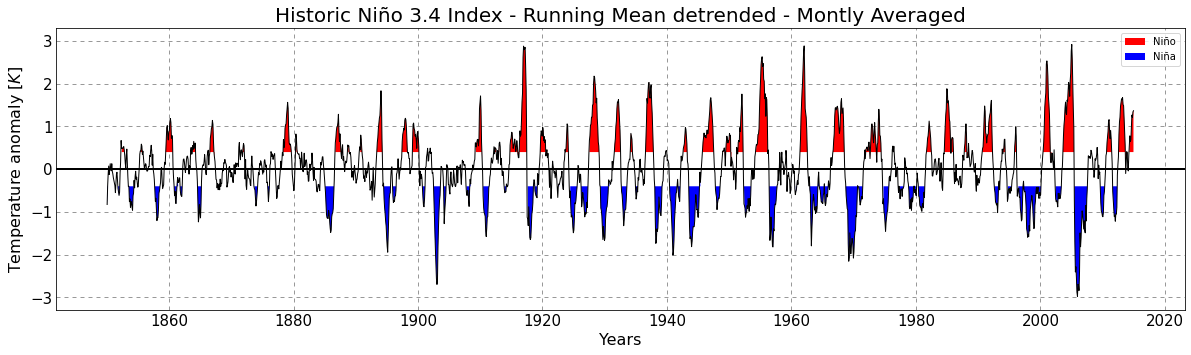

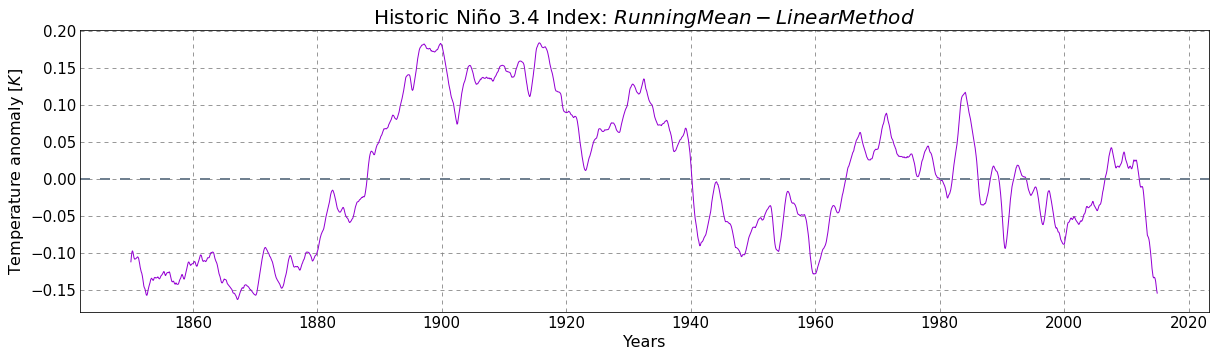

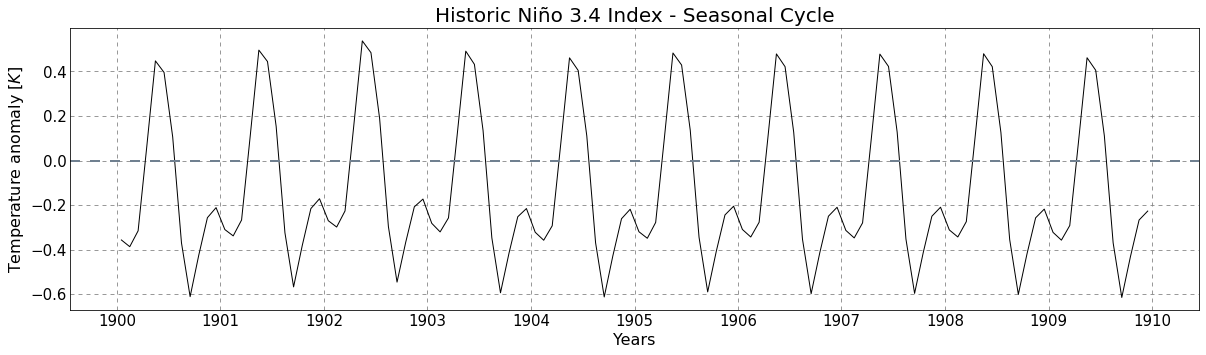

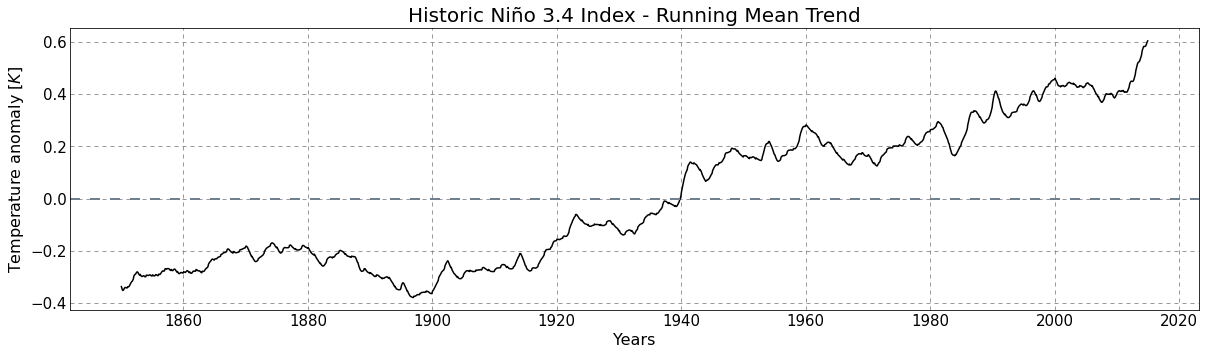

In [ ]:
###################################################################################

######################## Running Mean -30 anni ####################################

###################################################################################



###################################################################################
#############Ninõ Index, Running Mean Detrending, time mean over Months############
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(Index_MonthRM['time'], Index_MonthRM,  color='k', linewidth=1.0)
ax.fill_between(Index_MonthRM['time'], 0.4,  Index_MonthRM, where = Index_MonthRM.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red',
                interpolate=True, label='Niño')
ax.fill_between(Index_MonthRM['time'], -0.4, Index_MonthRM, where = Index_MonthRM.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue',
                interpolate=True, label='Niña')
# Add a legend on the Axes
ax.legend(loc = 'upper right')
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index - Running Mean detrended - Montly Averaged', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
ax.set_ylim(-3.3, 3.3)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, color='black', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-RMMonths.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-RMMonths.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

###################################################################################
###############Ninõ Index Bias: Polynomial - Lynear detrending#####################
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(Index_MonthRM['time'], Index_MonthRM-Index_MonthLinear,  color='darkviolet', linewidth=1.0)
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index: 'r'$Running Mean - Linear Method$', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, linestyle='--', color='slategray', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-BiasRMminusLinear.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-BiasRMminusLinear.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

###################################################################################
####################### Ninõ Index Seasonal Cycle #################################
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(Index_MonthRM['time'].sel(time=slice('1900-01-01','1910-01-01')), (Index_MonthLinearSC-Index_MonthRM).sel(time=slice('1900-01-01','1910-01-01')),  color='k', linewidth=1.0) #color='olivedrab'
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index - Seasonal Cycle', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, linestyle='--', color='slategray', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-SeasonalCycleRM.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-SeasonalCycleRM.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

###################################################################################
########################## Ninõ Index RM trend ####################################
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(Index_MonthRM['time'], RMTrend_plot,  color='k', linewidth=1.5) # color='dodgerblue'
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index - Running Mean Trend', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, linestyle='--', color='slategray', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-RMTrend.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-RMTrend.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

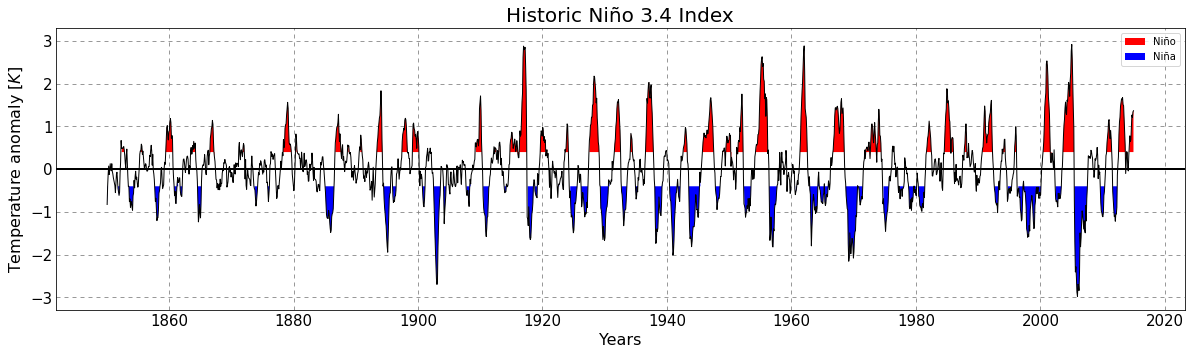

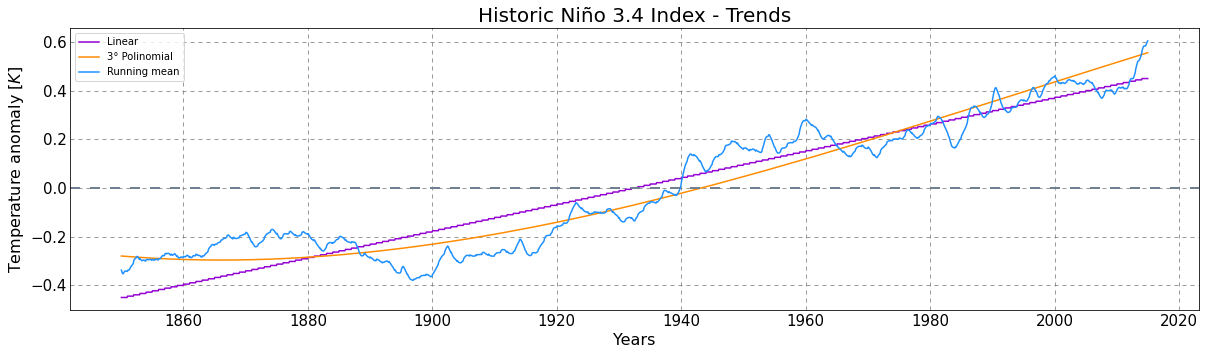

In [ ]:
###################################################################################
#############Ninõ Index, Running Mean Detrending, time mean over Months############
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(Index_MonthRM['time'], Index_MonthRM,  color='k', linewidth=1.0)
ax.fill_between(Index_MonthRM['time'], 0.4,  Index_MonthRM, where = Index_MonthRM.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red',
                interpolate=True, label='Niño')
ax.fill_between(Index_MonthRM['time'], -0.4, Index_MonthRM, where = Index_MonthRM.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue',
                interpolate=True, label='Niña')
# Add a legend on the Axes
ax.legend(loc = 'upper right')
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
ax.set_ylim(-3.3, 3.3)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, color='black', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-RM.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-RM.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

###################################################################################
############################ Ninõ Index Trends ####################################
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(temp['time'], Index_MonthTrend-Index_MonthLinear,  color='darkviolet', linewidth=1.5, label='Linear')
ax.plot(temp['time'], pol_trend,  color='darkorange', linewidth=1.5, label='3° Polinomial')
ax.plot(Index_MonthRM['time'], RMTrend_plot,  color='dodgerblue', linewidth=1.5, label='Running mean')
# Add a legend on the Axes
ax.legend(loc = 'upper left')
# Set title and x-y axis labels for the Axes
ax.set_title('Historic Niño 3.4 Index - Trends', fontsize=20)
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, linestyle='--', color='slategray', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-Trend.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-Trend.jpg',bbox_inches='tight', dpi=150)
#####################################################################################

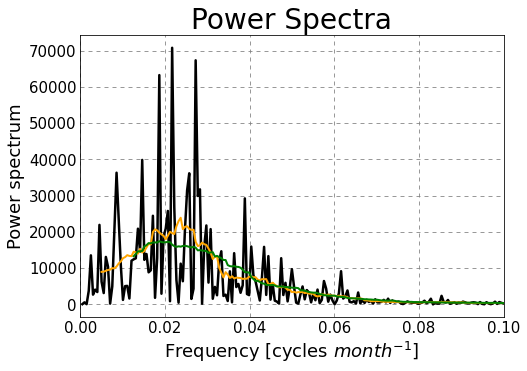

In [9]:
##############################################################################
############################ Power Spectra ###################################
##############################################################################

# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111)
fig, ax = plt.subplots(figsize=(6,4))
# Plot y versus x as lines in the Axes
ax.plot(freqs[idx], power_spec_den[idx], color='k', linewidth = 2.5)
#ps_low = ctl.butter_filter(ps, 20)
ps_low = ctl.running_mean(power_spec_den, 20)
ax.plot(freqs[idx], ps_low[idx], color='orange', linewidth = 2)
#ps_low = ctl.butter_filter(ps, 50)
ps_low = ctl.running_mean(power_spec_den, 50)
ax.plot(freqs[idx], ps_low[idx], color='green', linewidth = 2)
# Set x-axis limit
ax.set_xlim(0, 0.1)
# Set title and x-y axis labels for the Axes
ax.set_title('Power Spectra')
ax.set_xlabel('Frequency [cycles ' r'$month^{-1}]$')
ax.set_ylabel('Power spectrum')
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'PowerSpectra.jpg', bbox_inches='tight', dpi=300)

In [18]:
#SST
Toss=temp['tos'];
############## Ridimensionamento #################
TossR=xr.where(np.isnan(Toss), -9999, Toss).sel(lat=slice(-85,85)) #,lon=slice(115,295)
############## Maschera continentale ##############
Mask=np.isnan(TossR)[0,...]
############## Coordinate ##############
lon=TossR['lon'];
lat=TossR['lat'];
time=TossR['time'];

############## De-Trending, (Trend storico) del campo ##############
# Qui viene tolto anche il trend sulla variaibile su cui viene fatta la regressione, nel Task 6 no 
TossR_detrendedLinear=signal.detrend(TossR, axis=0, type='linear', bp=0, overwrite_data=False)

RM_field_Trend = TossR.rolling(time=360, min_periods=1, center=True).mean().dropna("time") # Running Mean (il .dropna("time") serve solo se min_periods > 1)
RM_field_Trend_plot = ctl.global_mean(RM_field_Trend.groupby('time.month')-RM_field_Trend.groupby('time.month').mean('time'))
TossR_DetrendedRM = TossR - RM_field_Trend

# Ritrasformazione in DataArray
TossR_detrendedLinear = xr.DataArray(TossR_detrendedLinear, 
        dims=['time', 'lat', 'lon'], coords={'time':time, 'lon':lon, 'lat':lat})
############## De-Trending, (CicloStagionale) del campo ##############
TossR_DetrendedDecycledLinear = (TossR_detrendedLinear.groupby('time.month') - 
                   TossR_detrendedLinear.groupby('time.month').mean('time'))
TossR_DetrendedDecycledYearLinear = TossR_detrendedLinear.groupby('time.year').mean('time')
TossR_DetrendedDecycledRM = (TossR_DetrendedRM.groupby('time.month') - 
                   TossR_DetrendedRM.groupby('time.month').mean('time'))
# TossR_DetrendedDecycledLinear è l'anomalia dell'SST nel tempo, è tale e quale a "anom_month_linear"
# Sono tutte anomalie dei campi, nella regressione va inserita indistintamente o l'anomalia o il campo
    
var_trendDM, var_interceptDM, var_trend_errDM, var_intercept_errDM, var_pvalDM = ctl.calc_trend_climatevar(
    Index_MonthLinear, TossR_DetrendedDecycledLinear, var_units = None);
var_trendD, var_interceptD, var_trend_errD, var_intercept_errD, var_pvalD = ctl.calc_trend_climatevar(
    Index_YearLinear, TossR_DetrendedDecycledYearLinear, var_units = None);
var_trendDMRM, var_interceptDMRM, var_trend_errDMRM, var_intercept_errDMRM, var_pvalDMRM = ctl.calc_trend_climatevar(
    Index_MonthRM, TossR_DetrendedDecycledRM, var_units = None);

############## Salvatqaggio Variabili Calcolate ########################
pickle.dump([var_trendD, var_trendDM, var_trendDMRM, var_pvalD, var_pvalDM, var_pvalDMRM], open(Dir_output + 'RegSSTStorico.p', 'wb'))

#var_trendD = np.where((var_trendD<0.0005) & (var_trendD>-0.0005), np.nan, var_trendD) #Maschera per vedere
            #anche i valori negativi che altrimenti per un problema di contourf non verebbero visualizzati
var_trendD=np.where(Mask, np.nan, var_trendD)
var_trendDM=np.where(Mask, np.nan, var_trendDM)

diff=np.array(var_trendDM-var_trendD)
diff=np.where(Mask, np.nan, diff)

################# SST per la composite map ################
TossTossR_Detrended_Decycled_Nino = (xr.where(Index_MonthRM_Nino>0.4, 
                                           TossR_DetrendedDecycledRM.sel(time=Index_MonthRM_Nino.time), np.nan)).mean('time')
TossTossR_Detrended_Decycled_Nina = (xr.where(Index_MonthRM_Nina<-0.4, 
                                           TossR_DetrendedDecycledRM.sel(time=Index_MonthRM_Nina.time), np.nan)).mean('time')
TossTossR_Detrended_Decycled_NN = TossTossR_Detrended_Decycled_Nino + TossTossR_Detrended_Decycled_Nina


#Box nel pacifico per Ninõ
las, lan=-5, 5
low, loe=190, 240
# Create a figure with Equidist-Cylindrical proj.
proj0 = ccrs.PlateCarree()
proj=ccrs.PlateCarree(central_longitude=205)

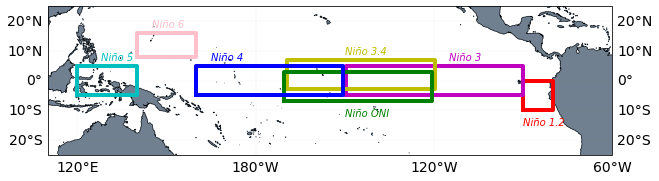

In [61]:
################################################################################################
######################################### Ninõ Indexes #########################################
################################################################################################
#from matplotlib.patches import Polygon
# Imposta la figura
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=proj)
# Risoluzione
res = '50m'
# Aggiunge la terra
ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray')
# Bordi costieri
ax.coastlines(resolution='50m', linewidths=0.5)
# Griglia
ax.gridlines(linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
# Definisce l'estensione
ax.set_extent([110, 300, -25, 25], crs=proj0) #[130, 300, -20, 20]
# Ninō 3.4 Box
Nino12x=[270, 280, 280, 270, 270]
Nino3x=[210.5, 270, 270, 210.5, 210.5]
Nino34x=[191.5, 240.5, 240.5, 190.5, 190.5]
NinoONIx=[189.5, 239.5, 239.5, 189.5, 189.5]#[190, 240, 240, 190, 190]
Nino4x=[160, 209.5, 209.5, 160, 160]
Nino5x=[120, 140, 140, 120, 120]
Nino6x=[140, 160, 160, 140, 140]

Nino12y=[-10, -10, 0, 0, -10]
Nino3y=[-5, -5, 5, 5, -5]
Nino34y=[-3, -3, 7, 7, -3]
NinoONIy=[-7, -7, 3, 3, -7]
Nino4y=[-5, -5, 5, 5, -5]
Nino5y=[-5, -5, 5, 5, -5]
Nino6y=[8, 8, 16, 16, 8]

ax.plot(Nino12x, Nino12y, color='r', linewidth=4, transform=proj0)
ax.plot(Nino3x, Nino3y, color='m', linewidth=4, transform=proj0)
ax.plot(Nino34x, Nino34y, color='y', linewidth=4, transform=proj0) #, linestyle='--'
# polygon = Polygon([(190, -5), (240, -5), (240, 5), (190, 5), (190, -5)], hatch='///',
#                      facecolor='white', edgecolor='green', transform=proj0)
# ax.add_patch(polygon)
ax.plot(NinoONIx, NinoONIy, color='g', linewidth=4, transform=proj0)
ax.plot(Nino4x, Nino4y, color='b', linewidth=4, transform=proj0)
ax.plot(Nino5x, Nino5y, color='c', linewidth=4, transform=proj0)
ax.plot(Nino6x, Nino6y, color='pink', linewidth=4, transform=proj0)
# Testo
ax.text(65, -15, 'Niño 1.2', style='italic', color='r', fontsize=10)
ax.text(40, 7, 'Niño 3', style='italic', color='m', fontsize=10)
ax.text(5, 9, 'Niño 3.4', style='italic', color='y', fontsize=10)
ax.text(5, -12, 'Niño ONI', style='italic', color='g', fontsize=10)
ax.text(-40, 7, 'Niño 4', style='italic', color='b', fontsize=10)
ax.text(-77, 7, 'Niño 5', style='italic', color='c', fontsize=10)
ax.text(-60, 18, 'Niño 6', style='italic', color='pink', fontsize=10)
# set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# Save the figure
plt.savefig('/home/montanarini/ELNINO/images/NinoIndexes.pdf', bbox_inches='tight')
plt.savefig('/home/montanarini/ELNINO/images/NinoIndexes.png', bbox_inches='tight', dpi=150)
# Mostra il grafico
plt.show()


/tmp/ipykernel_5341/3938482012.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


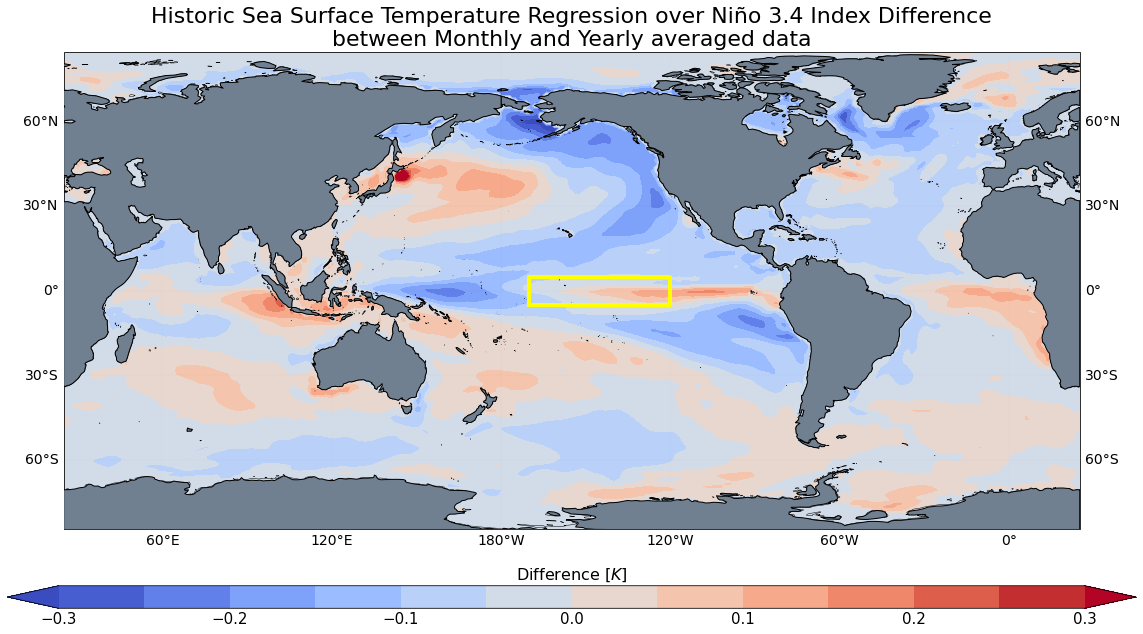

In [10]:
################################################################################################
################## Sea Surface Temperature regression over Ninõ 3.4 Index ######################
################### discrepance between data yearly and monthly averaged #######################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-0.3,0.3, 13)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') # In questo caso non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
discrepance = var_trendDM-var_trendD
# Hide white longitude line
lon_o = lon.copy() #originale
discrepance, lon_o = cutil.add_cyclic_point(discrepance, coord = lon_o)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, discrepance, cmap='coolwarm', transform=proj0,
                     levels=levels, extend='both') #, extend='both' ; 'jet';#'magma'; #cool
#scalar.set_clim(-6,6)
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('Difference ' r'$[K]$', fontsize=16) #SST Amplification [K/K]
# Set a title for the axes.
ax.set_title('Historic Sea Surface Temperature Regression over Niño 3.4 Index Difference\nbetween Monthly and Yearly averaged data', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='k', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Save the current figure to a file
fig.savefig(Dir_images+'RegressionSSTDiscrepance_MonthMinusYear.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'RegressionSSTDiscrepance_MonthMinusYear.jpg',bbox_inches='tight', dpi=150)
# Display the figure
plt.show()

/tmp/ipykernel_5341/3197578234.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


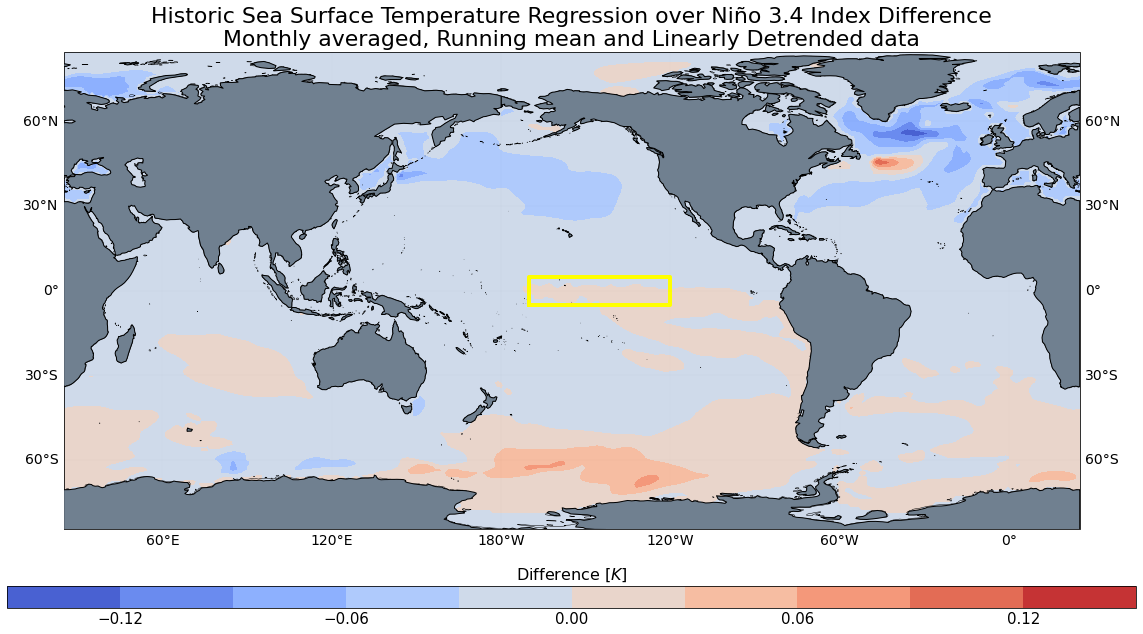

In [ ]:
################################################################################################
################## Sea Surface Temperature regression over Ninõ 3.4 Index ######################
################ discrepance between monthly data RM and Linearly Detrended ####################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-0.15,0.15, 11)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') # In questo caso non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
discrepance = var_trendDMRM-var_trendDM
# Hide white longitude line
lon_o = lon.copy() #originale
discrepance, lon_o = cutil.add_cyclic_point(discrepance, coord = lon_o)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, discrepance, cmap='coolwarm', transform=proj0,
                     levels=levels) #, extend='both' ; 'jet';#'magma'; #cool
#scalar.set_clim(-6,6)
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('Difference ' r'$[K]$', fontsize=16) #SST Amplification [K/K]
# Set a title for the axes.
ax.set_title('Historic Sea Surface Temperature Regression over Niño 3.4 Index Difference\nMonthly averaged, Running mean and Linearly Detrended data', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='k', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Save the current figure to a file
fig.savefig(Dir_images+'RegressionSSTDiscrepance_RMMinusLinear.pdf',bbox_inches='tight', dpi=300)
fig.savefig(Dir_images+'RegressionSSTDiscrepance_RMMinusLinear.jpg',bbox_inches='tight', dpi=150)
# Display the figure
plt.show()

/tmp/ipykernel_5341/1740304337.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


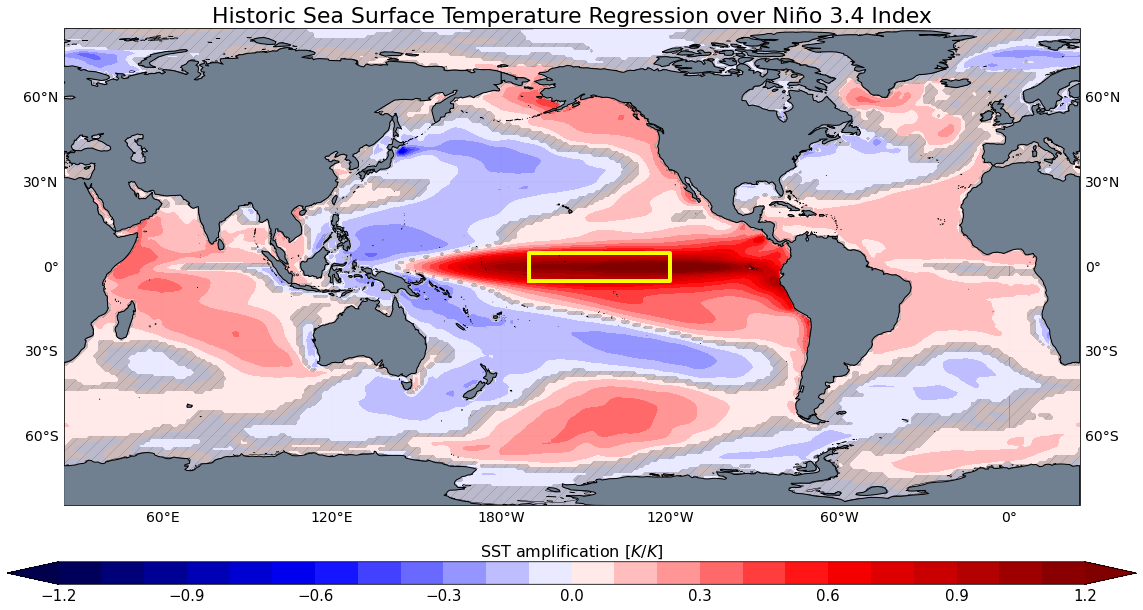

In [ ]:
################################################################################################
###################### SST & p value Regression over Ninõ 3.4 Index ############################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-1.2,1.2, 25)
levels=np.round(levels, 1)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') #-->in questo caso non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
#ax.set_global()
# Hide white longitude line
lon_o = lon.copy() #originale
lon_oo = lon.copy() #originale
var_trendDMRM, lon_o = cutil.add_cyclic_point(var_trendDMRM, coord = lon_o)
var_pvalDMRM, lon_oo = cutil.add_cyclic_point(var_pvalDMRM, coord = lon_oo)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, var_trendDMRM, cmap='seismic', transform=proj0,
                     levels=levels, extend='both') #, extend='both' ; 'jet';#'coolwarm'; #cool
#scalar.set_clim(-6,6)
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('SST amplification ' r'$[K/K]$', fontsize=16) #SST Amplification [K/K]
# Set a title for the axes.
#plt.suptitle('Ninõ3.4 Index regression over Sea Surface Temperature', fontsize=22)
#ax.set_title('Discrepance between index regression evaluated throught'+'\n'+'the SST and 3.4 Index detrended and de-seasonalized monthly sampled and'+'\n'+, fontsize=13)
ax.set_title('Historic Sea Surface Temperature Regression over Niño 3.4 Index', fontsize=22)
#p-value/significativity shading
density=2
scalarH = ax.contourf(lon_oo, lat, var_pvalDMRM > 0.05, transform=proj0, colors='none',
            levels=[0.5,1.5], hatches=[density*'/'], alpha=0.2) #ALPHA setta la trasparenza
# create a legend for the hatches contour set
#artists, labels = scalarH.legend_elements(str_format='{:2.1f}'.format)
#labels = ['p-value > 0.05']
#legend = ax.legend(artists, labels, handleheight=2, framealpha=1, loc = 'upper left', frameon=True)
#legend.set_zorder(100) # Posiziona la legenda in primo piano
#legend.set_in_layout(False)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'RegressionSST-Hist.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'RegressionSST-Hist.jpg',bbox_inches='tight', dpi=150)

/tmp/ipykernel_5341/3349604805.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


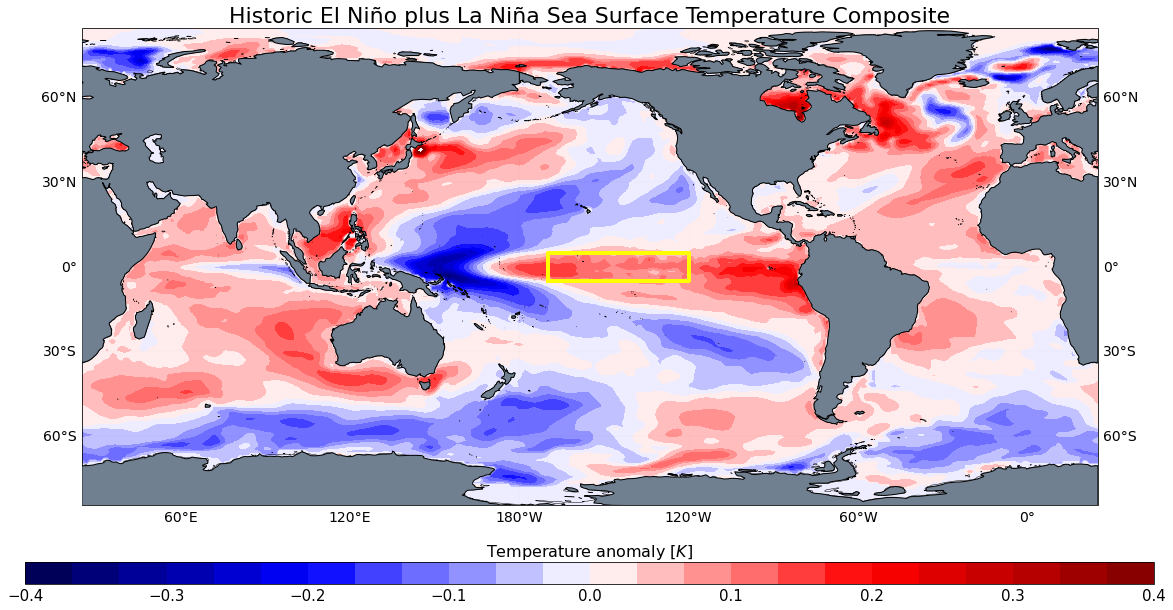

In [ ]:
################################################################################################
########################## SST composite maps for Ninõ 3.4 Index ###############################
######################################### Nino + Nina ##########################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-0.4, 0.4, 25) #np.max(sst)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') ##-->non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
# Hide white longitude line
lon_o = lon.copy() #originale
TossTossR_Detrended_Decycled_NN, lon_o = cutil.add_cyclic_point(TossTossR_Detrended_Decycled_NN, coord = lon_o)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, TossTossR_Detrended_Decycled_NN,
                     cmap='seismic', transform=proj0, levels=levels) #, extended='min';'jet';#'magma'
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('Temperature anomaly ' r'$[K]$', fontsize=16)
# Set a title for the axes.
ax.set_title('Historic El Niño plus La Niña Sea Surface Temperature Composite', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'compositeNino+Nina-Hist.pdf', bbox_inches='tight')
fig.savefig(Dir_images+'compositeNino+Nina-Hist.jpg', bbox_inches='tight', dpi=150)

/tmp/ipykernel_5341/2593268114.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


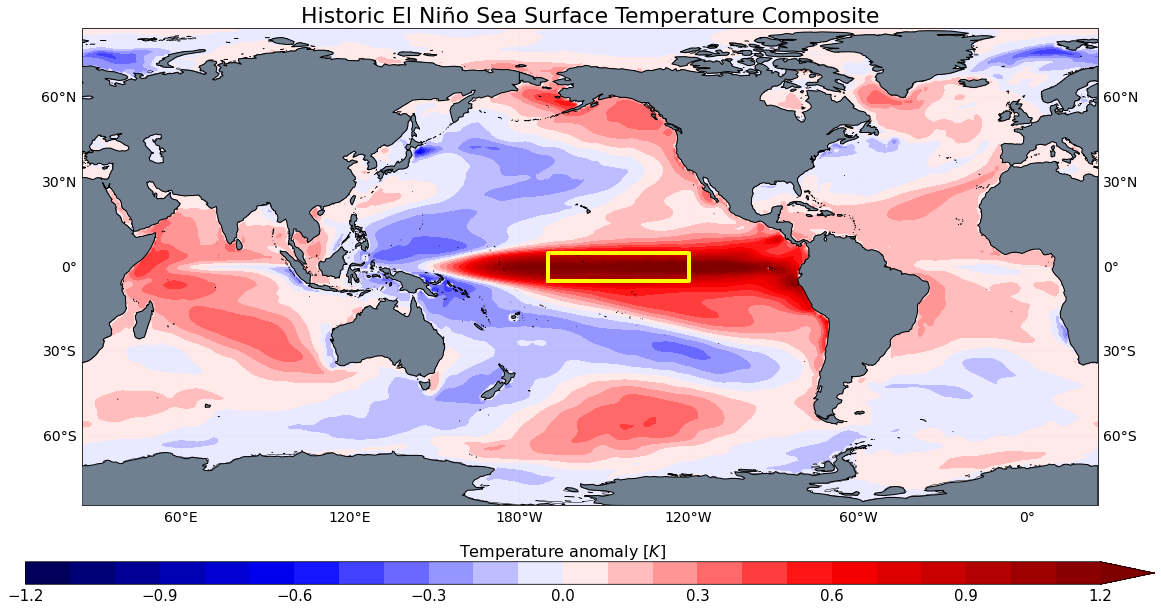

In [ ]:
################################################################################################
########################## SST composite maps for Ninõ 3.4 Index ###############################
########################################### Nino ###############################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-1.2, 1.2, 25) #np.max(sst)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') ##-->non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
# Hide white longitude line
lon_o = lon.copy() #originale
TossTossR_Detrended_Decycled_Nino, lon_o = cutil.add_cyclic_point(TossR_Detrended1_Decycled_Nino, coord = lon_o)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, TossR_Detrended1_Decycled_Nino,
                     cmap='seismic', transform=proj0, levels=levels, extend='max') #, extended='min';'jet';#'magma'
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('Temperature anomaly ' r'$[K]$', fontsize=16)
# Set a title for the axes.
ax.set_title('Historic El Niño Sea Surface Temperature Composite', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'compositeNino-Hist.pdf', bbox_inches='tight')
fig.savefig(Dir_images+'compositeNino-Hist.jpg', bbox_inches='tight', dpi=150)

/tmp/ipykernel_5341/2982432659.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


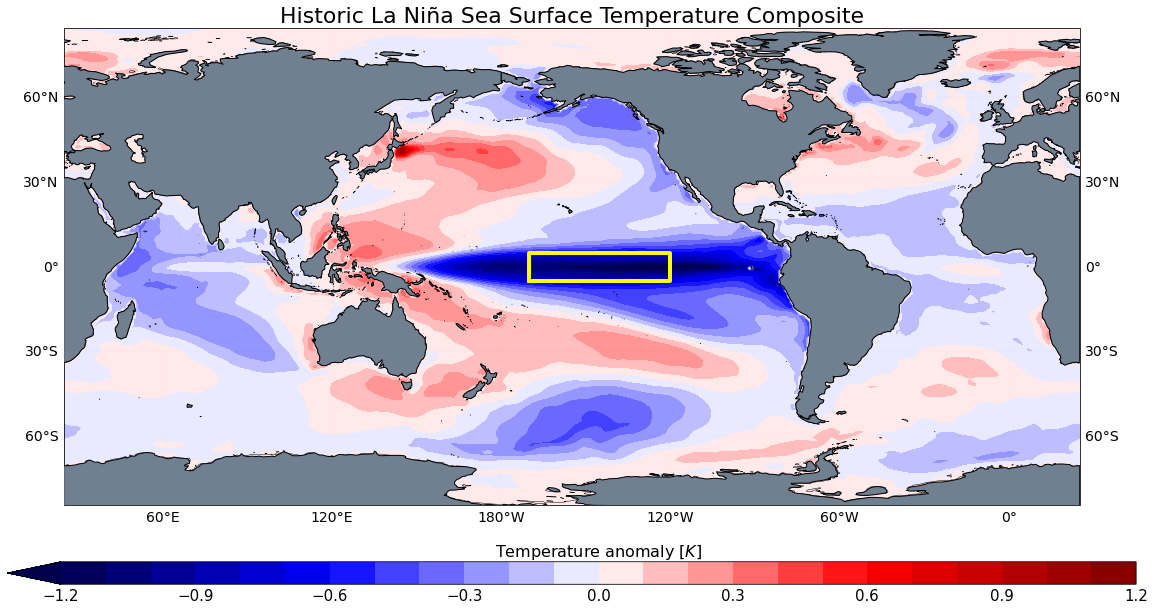

In [ ]:
################################################################################################
########################## SST composite maps for Ninõ 3.4 Index ###############################
########################################### Nina ###############################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-1.2, 1.2, 25) #np.max(sst)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') ##-->non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
# Hide white longitude line
lon_o = lon.copy() #originale
TossTossR_Detrended_Decycled_Nina, lon_o = cutil.add_cyclic_point(TossTossR_Detrended_Decycled_Nina, coord = lon_o)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, TossTossR_Detrended_Decycled_Nina,
                     cmap='seismic', transform=proj0, levels=levels, extend='min') #'jet';#'magma'
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('Temperature anomaly ' r'$[K]$', fontsize=16)
# Set a title for the axes.
ax.set_title('Historic La Niña Sea Surface Temperature Composite', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'compositeNina-Hist.pdf', bbox_inches='tight')
fig.savefig(Dir_images+'compositeNina-Hist.jpg', bbox_inches='tight', dpi=150)